<a href="https://colab.research.google.com/github/hoffera/PDI-Projeto-M2/blob/main/Parte_2_%E2%80%93_Segmenta%C3%A7%C3%A3o_Morfol%C3%B3gica_e_Gap_Filling_para_Contagem_de_C%C3%A9lulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

In [40]:
def grayscale(img):
    B, G, R = cv2.split(img)
    img_grayscale_pondered = 0.299*B+0.587*G+0.114*R
    img_grayscale_pondered = np.array(img_grayscale_pondered, dtype=np.uint8)
    return img_grayscale_pondered

In [41]:
def add_padding(img, padding_height, padding_width):
    n, m = img.shape

    padded_img = np.zeros((n + padding_height * 2, m + padding_width * 2))
    padded_img[padding_height : n + padding_height, padding_width : m + padding_width] = img

    return padded_img

In [42]:
def conv2d(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.uint8)


In [43]:
def gauss_create(sigma=1, size_x=3, size_y=3):
    x, y = np.meshgrid(np.linspace(-1,1,size_x), np.linspace(-1,1,size_y))
    calc = 1/((2*np.pi*(sigma**2)))
    exp = np.exp(-(((x**2) + (y**2))/(2*(sigma**2))))

    return exp*calc

In [44]:
def filtro_gaussiano(img):
  gaus_3x3 = gauss_create(sigma=1, size_x=3, size_y=3)
  gaus_5x5 = gauss_create(sigma=1, size_x=5, size_y=5)
  gaus_7x7 = gauss_create(sigma=1, size_x=7, size_y=7)

  img_gauss = conv2d(img, gaus_3x3, padding=True)

  return img_gauss


# Pré-processamento

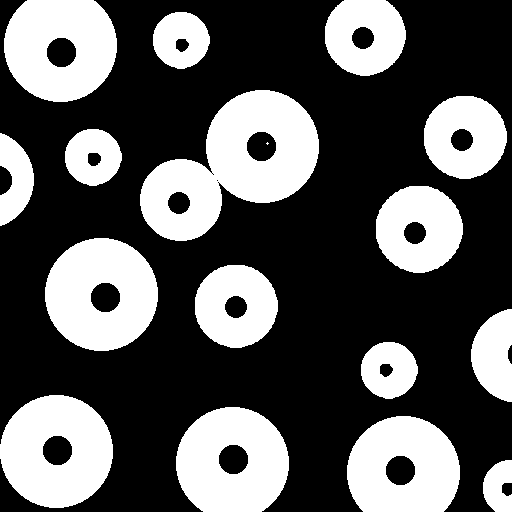

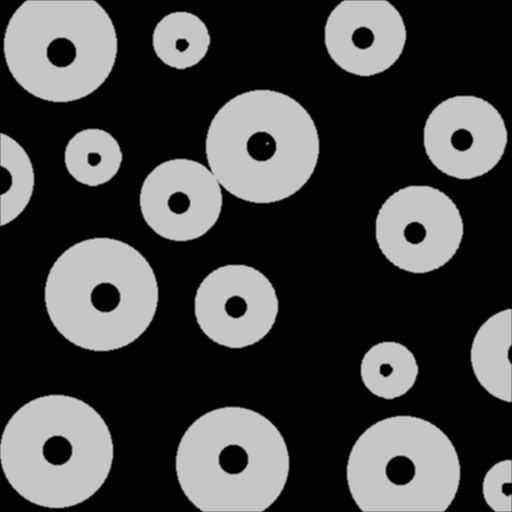

In [45]:
imagem_1 = cv2.imread('/content/gap-region-filling (1).tif',1)


#APLICANDO GRAYSCALE
imagem_1_grayscale = grayscale(imagem_1)
cv2_imshow(imagem_1_grayscale)

#APLICAR RUIDO

#APLICANDO GAUSSIANO
imagem_1_gauss = filtro_gaussiano(imagem_1_grayscale)

cv2_imshow(imagem_1_gauss)

# Limiarização

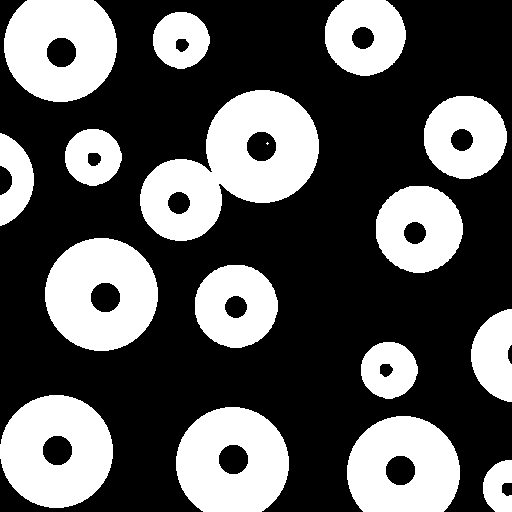

In [57]:
#limiar
img_in = imagem_1_gauss

img_out = np.zeros(img_in.shape)

for i in range(img_in.shape[0]):
    for j in range(img_in.shape[1]):
        if img_in[i,j] < 95 :
            img_out[i,j] = 0
        else:
            img_out[i,j] = 255 #img_in[i,j]

img_limiar = np.array(img_out, dtype = np.uint8)


cv2_imshow(img_limiar)


# metodo = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
# ret, imgBin = cv2.threshold(imagem_1_gauss, 0, 255, metodo)


# print("O melhor limiar é:", ret)

# cv2_imshow(imgBin)



# Operações morfológicas


In [73]:
def create_element(size_x, size_y):
   element = np.zeros((size_x, size_y), dtype = np.uint8)
   for i in range(size_x):
      for j in range(size_y):
         element[i,j] = 255
   return element

def threashold(img_in):
   img_out = np.zeros(img_in.shape)

   for i in range(img_in.shape[0]):
      for j in range(img_in.shape[1]):
         if img_in[i,j] < 127 :
               img_out[i,j] = 0
         else:
               img_out[i,j] = 255 #img_in[i,j]

   img_out = np.array(img_out, dtype = np.uint8)
   return img_out

In [77]:
def morf_dilate_erode(img, kernel, padding=True, dilate=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width


    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)

    if dilate == True: # Analisa se há algum hit entre elemento e janela
      print("Dilate Operation")
      for i_img in range(img_height):  # Loop usando i
         for j_img in range(img_width):  # Loop usando j
               match_element = 0
               for i_kernel in range(k_height):
                  for j_kernel in range(k_width):
                           if (kernel[i_kernel, j_kernel] == 255):
                              if(padded_img[i_img+i_kernel, j_img+j_kernel] == kernel[i_kernel, j_kernel]):
                                 match_element = 1
               if(match_element == 1):
                  output[i_img, j_img] = 255
               else:
                  output[i_img, j_img] = 0
    else:
      print("Erode Operation")
      for i_img in range(img_height):  # Loop usando i
         for j_img in range(img_width):  # Loop usando j
               match_element = 1
               for i_kernel in range(k_height):
                  for j_kernel in range(k_width):
                           if (kernel[i_kernel, j_kernel] == 255):
                              if(padded_img[i_img+i_kernel, j_img+j_kernel] != kernel[i_kernel, j_kernel]):  # Analisa se não há algum hit entre elemento e janela
                                 match_element = 0
               if(match_element == 0):
                  output[i_img, j_img] = 0
               else:
                  output[i_img, j_img] = 255

    return np.array(output, dtype=np.uint8)

Dilate Operation
Erode Operation


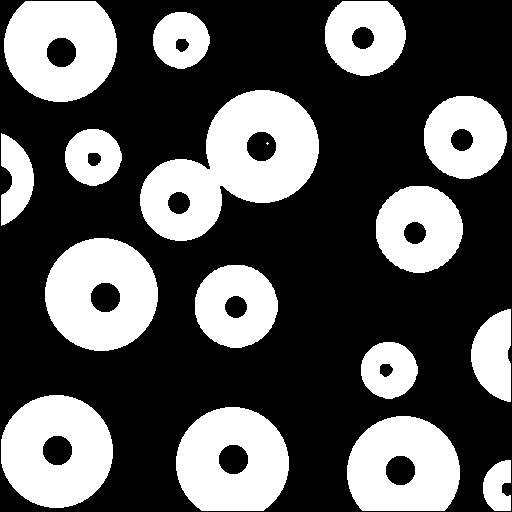

In [87]:
#Fechamento


element = create_element(3,3)
image_bin = threashold(img_limiar)

dilated  = morf_dilate_erode(image_bin, element, padding=True, dilate=True)
closed   = morf_dilate_erode(dilated, element, padding=True, dilate=False)

cv2_imshow(closed)

In [ ]:
#GAP-FILLING

Erode Operation
Dilate Operation


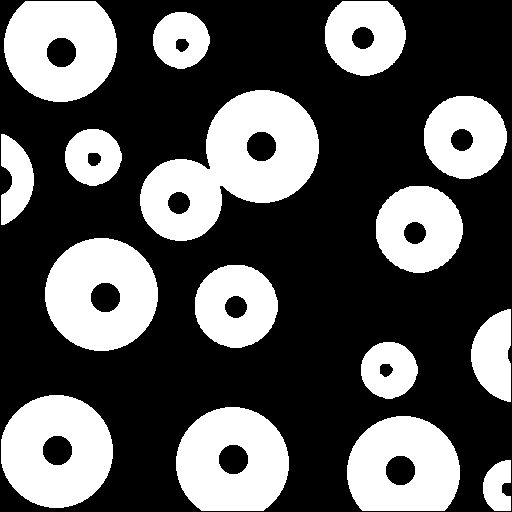

In [89]:
#Abertura

image_bin = threashold(closed)

erode  = morf_dilate_erode(image_bin, element, padding=True, dilate=False)
open   = morf_dilate_erode(erode, element, padding=True, dilate=True)

cv2_imshow(open)

## CONTAR


In [ ]:
def vizinhos(img, y, x):
    vizinhos = []
    if y + 1 < len(img):
        vizinhos.append((y + 1, x))
    if y - 1 >= 0:
        vizinhos.append((y - 1, x))
    if x + 1 < len(img[y]):
        vizinhos.append((y, x + 1))
    if x - 1 >= 0:
        vizinhos.append((y, x - 1))
    return vizinhos

def bfs(img, ponto, pintado):
    y, x = ponto
    img[y][x] = pintado
    fila = [ponto]
    while fila:
        y, x = fila.pop()
        for vizinho in vizinhos(img, y, x):
            y_v, x_v = vizinho
            cor = img[y_v][x_v]
            if cor == 255:
                img[y_v][x_v] = pintado
                fila.append(vizinho)

def contar_objetos(img):
    pintado = 5
    total_objetos = 0
    for y in range(len(img)):
        for x in range(len(img[y])):
            if img[y][x] == 255:
                total_objetos += 1
                bfs(img, (y, x), pintado)
                pintado += 5  # corrigido
    print('Quantidade de objetos:', total_objetos)

# Defina o caminho diretamente no Colab

img = abertura

# Binariza
ret, imgT = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
cv2_imshow(imgT)

# Conta e pinta os objetos
contar_objetos(imgT)

# Mostra imagem resultante com objetos pintados
cv2_imshow(imgT)

# Histograma
n, bins, patches = plt.hist(imgT.ravel(), 256, [1, 255])
plt.title("Histograma")
plt.xlabel("Intensidade")
plt.ylabel("Frequência")
plt.show()


# CONTAR COR

In [67]:

imagem = 255 - abertura
# imagem =  abertura
cv2_imshow(imagem)

NameError: name 'abertura' is not defined

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import time  # para dar uma pausa opcional entre exibições

def vizinhos(img, y, x):
    vizinhos = []
    if y + 1 < img.shape[0]:
        vizinhos.append((y + 1, x))
    if y - 1 >= 0:
        vizinhos.append((y - 1, x))
    if x + 1 < img.shape[1]:
        vizinhos.append((y, x + 1))
    if x - 1 >= 0:
        vizinhos.append((y, x - 1))
    return vizinhos

def bfs(img_bin, img_color, ponto, cor):
    y, x = ponto
    img_bin[y][x] = 0
    fila = [ponto]
    while fila:
        y, x = fila.pop()
        img_color[y, x] = cor
        for vizinho in vizinhos(img_bin, y, x):
            y_v, x_v = vizinho
            if img_bin[y_v][x_v] == 255:
                img_bin[y_v][x_v] = 0
                fila.append((y_v, x_v))

    # Exibe a imagem após pintar o objeto
    cv2_imshow(img_color)
    time.sleep(0.5)  # opcional: pausa de 0.5s entre objetos (pode remover)

def contar_e_pintar_objetos(img_bin, img_color):
    total_objetos = -1
    for y in range(img_bin.shape[0]):
        for x in range(img_bin.shape[1]):
            if img_bin[y][x] == 255:
                total_objetos += 1
                print('Quantidade de objetos:', total_objetos)
                bfs(img_bin, img_color, (y, x), (0, 0, 255))  # vermelho
    print('Quantidade de objetos:', total_objetos)

# Carregue a imagem grayscale na variável `imagem`
# Ex: imagem = cv2.imread("imagem.png", cv2.IMREAD_GRAYSCALE)
img = imagem

# Binariza
ret, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
cv2_imshow(img_bin)

# Cria imagem colorida
img_color = cv2.cvtColor(img_bin, cv2.COLOR_GRAY2BGR)

# Conta e pinta objetos
contar_e_pintar_objetos(img_bin.copy(), img_color)

# # Histograma final
# n, bins, patches = plt.hist(cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY).ravel(), 256, [1, 255])
# plt.title("Histograma")
# plt.xlabel("Intensidade")
# plt.ylabel("Frequência")
# plt.show()
